In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
from tabulate import tabulate

from trainer import Trainer, generate_data_iter
import utils
import cam

def plot_test_pic(cam_img, insertion, deletion):
    fig = plt.figure(figsize = (13, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cam_img)
    plt.title('CAM Image')
    plt.axis('off')
    
    x_axis = np.linspace(0, 1, len(insertion))
    plt.subplot(1, 3, 2)
    plt.plot(x_axis, insertion)
    plt.title('Insertion Curve')
    plt.fill_between(x_axis, 0, insertion, alpha=0.4)
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])
    
    plt.subplot(1, 3, 3)
    plt.plot(x_axis, deletion)
    plt.title('Deletion Curve')
    plt.fill_between(x_axis, 0, deletion, alpha=0.4)
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])

In [2]:
model_mode, dataset, seed, cuda = 'densenet121', 'Imagenette', 0, 1
if model_mode == 'resnet18': target_layer = 'layer4'
elif model_mode == 'efficientnet_b0': target_layer = 'conv_head'
elif model_mode == 'densenet121': target_layer = 'features'
else: target_layer = 'blocks'
fig_num = 100
metrics = {}

utils.set_random_seed(seed)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)
trainer.load()
# top1_acc, top5_acc = trainer.evaluate_model()
# print(f'Seed: {seed}    Top 1 Acc: {top1_acc * 100:4.2f}%    Top 5 Acc: {top5_acc * 100:4.2f}%')

test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))

df_pth = f'./thesis/cam_metrics/{dataset}/'
if not os.path.exists(df_pth):
    os.makedirs(df_pth)
    
cam_np_pth = f'thesis/cam_pics/{dataset}/'
if not os.path.exists(cam_np_pth):
    os.makedirs(cam_np_pth)

### CAM

| Average Incr | 0.38      |
| Average Drop | 0.0138494 |
| Insertion    | 0.863803  |
| Deletion     | 0.452972  |
CAM, Pred: 1, Label: 1, Prob: 99.99%


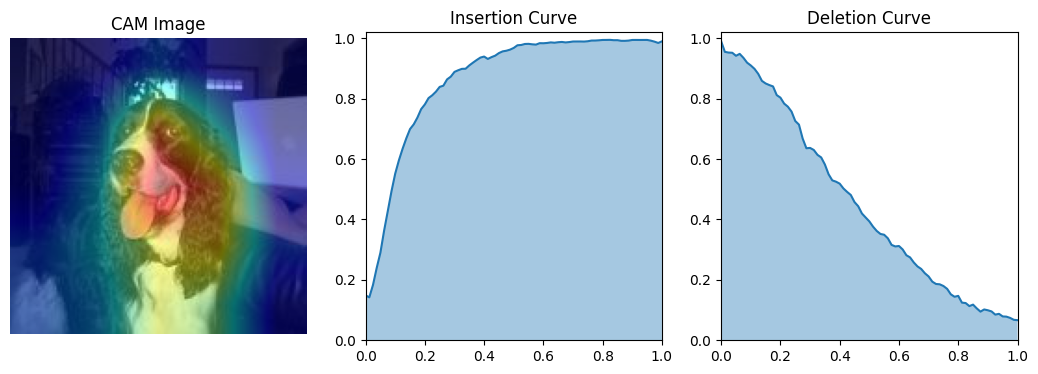

In [4]:
if model_mode == 'resnet18' or model_mode == 'densenet121':
    if model_mode == 'resnet18': fc_layer = 'fc'
    else: fc_layer = 'classifier'
    mycam = cam.CAM(trainer.model, dataset, target_layer, fc_layer, cuda = cuda)
    cam_name = mycam.__class__.__name__
    cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
    metrics[mycam.__class__.__name__] = {
        'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
        'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
    }
    np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
    print(tabulate(
        list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
    ))
    
    idx = 8
    print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
    plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Grad-CAM

| Average Incr | 0.38      |
| Average Drop | 0.0138643 |
| Insertion    | 0.863804  |
| Deletion     | 0.452971  |
GradCAM, Pred: 1, Label: 1, Prob: 99.99%


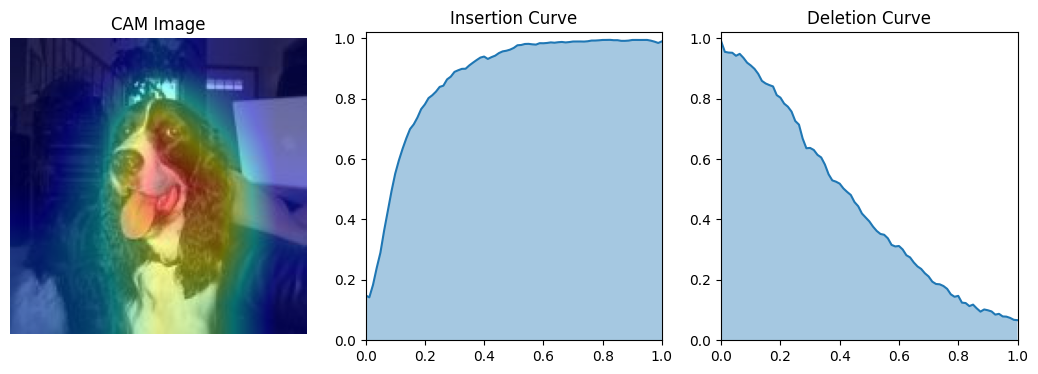

In [5]:
mycam = cam.GradCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Grad-CAM++

| Average Incr | 0.31      |
| Average Drop | 0.0188489 |
| Insertion    | 0.862288  |
| Deletion     | 0.459711  |
GradCAMpp, Pred: 1, Label: 1, Prob: 99.99%


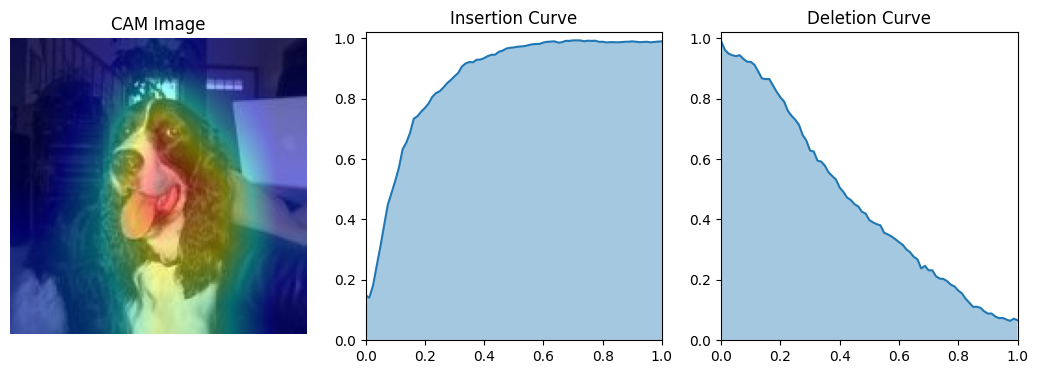

In [6]:
mycam = cam.GradCAMpp(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Smooth Grad-CAM++

In [7]:
mycam = cam.SMGradCAMpp(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 1; 47.54 GiB total capacity; 7.50 GiB already allocated; 12.88 MiB free; 7.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### LayerCAM

In [7]:
mycam = cam.LayerCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

: 

: 

### XGrad-CAM

| Average Incr | 0.38      |
| Average Drop | 0.0138578 |
| Insertion    | 0.863804  |
| Deletion     | 0.452978  |
XGradCAM, Pred: 1, Label: 1, Prob: 99.99%


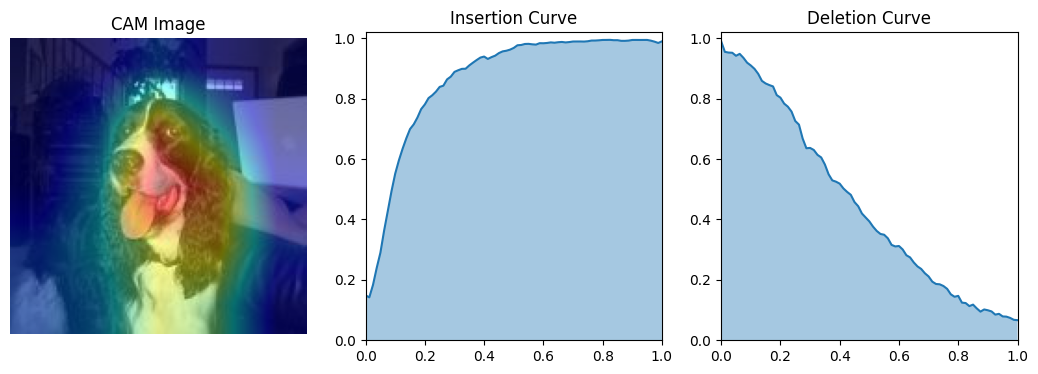

In [ ]:
mycam = cam.XGradCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Score-CAM

| Average Incr | 0.51       |
| Average Drop | 0.00417368 |
| Insertion    | 0.867381   |
| Deletion     | 0.477463   |
ScoreCAM, Pred: 1, Label: 1, Prob: 99.99%


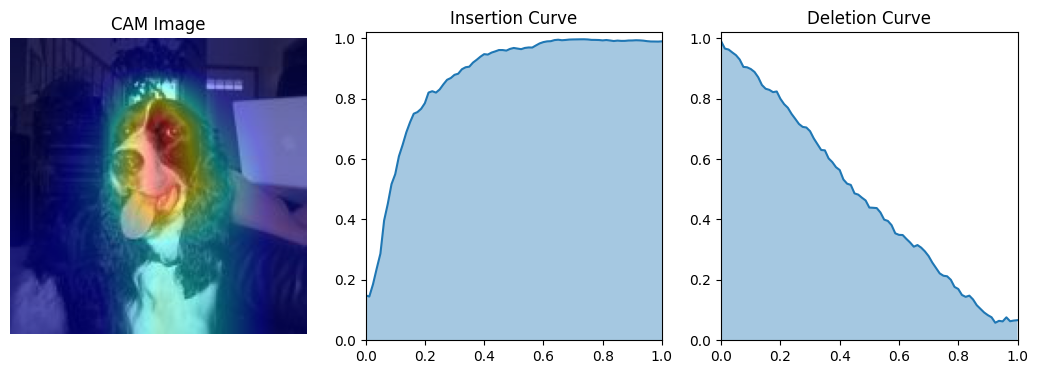

In [ ]:
mycam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### SS-CAM

In [2]:
mycam = cam.SSCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

NameError: name 'cam' is not defined

### IS-CAM

In [ ]:
mycam = cam.ISCAM(trainer.model, dataset, target_layer, cuda = cuda)
cam_name = mycam.__class__.__name__
cam_imgs, preds, probs, metrics_cam = mycam(imgs, metric = True)
metrics[cam_name] = {
    'Average Incr': metrics_cam['Average Incr'], 'Average Drop': metrics_cam['Average Drop'],
    'Insertion':  metrics_cam['Insertion'], 'Deletion': metrics_cam['Deletion'],
}
np.save(cam_np_pth + f'{cam_name}-{dataset}-{model_mode}-seed{seed}.npy', cam_imgs)
print(tabulate(
    list(metrics[mycam.__class__.__name__].items()), tablefmt ='orgtbl'
))
    
idx = 8
print(f'{cam_name}, Pred: {preds[idx]}, Label: {labels[idx]}, Prob: {probs[idx]*100:4.2f}%')
plot_test_pic(cam_imgs[idx], metrics_cam['inse_score'], metrics_cam['dele_score'])

### Metrics

In [ ]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(df_pth + f'CAM-{model_mode}-{dataset}-seed{seed}.csv')
metrics_df